# Conditional Generative Adversarial Networks (cGANs)

**Learning Objectives**

- Build a Conditional GAN architecture (consisting of a generator and discriminator) in Keras 
- Define the loss for the generator and discriminator
- Define a training step for the GAN using tf.keras.Model subcrassing
- Train the cGAN on the MNIST dataset

## Introduction
This notebook demonstrates how to build and train a [Conditional Generative Adversarial Network](https://arxiv.org/abs/1411.1784).

The basic GAN that we discussed in the previous lab(deepconv-gan.ipynb) is trained in a completely unsupervised way on images that we want to learn how to generate. <br>
Latent representations, such as a random noise vector, are then used to explore and sample the learned image space.

A simple enhancement is to add an external flag to our inputs with a label.<br>
For instance, consider the MNIST dataset, which consists of handwritten digits from 0 to 9. 

Normally, the GAN just learns the distribution of digits, and when the generator is given random noise vectors, it generates different digits.

![Basic GAN](https://user-images.githubusercontent.com/6895245/171208971-3ff1c023-cdd7-47c2-b734-77e07b8eb6ac.png)

However, which digits are generated cannot be controlled.

During training, as with MNIST, we may know the actual label or class designation for each image. <br>
That extra information can be included as a feature in our GAN training that can then be used at inference time. 

With conditional GANs (cGANs), image generation can be conditional on the label, so we are able to home in on the specific digit of interest’s distribution. 

Then, at inference time we can create an image of a specific digit by passing in the desired label instead of receiving a random digit.

![cGAN](https://user-images.githubusercontent.com/6895245/171209451-4b95c856-fafa-40b4-87b6-c7232c1de841.png)

In this notebook, you are going to learn how to build conditional GAN.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(f"Found GPU at: {device_name}")

2.8.1
Found GPU at: /device:GPU:0


2022-06-01 12:50:54.450721: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 12:50:55.059365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 12:50:55.070828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 12:50:55.071444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Constants

In [3]:
IMAGE_SHAPE = (28, 28, 1)
NUM_CLASSES = 10
LATENT_DIM = 512

## Create the generator and discriminator models for Conditional GAN

In the previous lab, vanilla GAN was defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model), but here we use [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) to create more complicated models for Conditional GAN.

Firstly, we need to define layers to embed label (0-9) information, which will be used both in Generator and Discriminator.<br>
The embedding should be rank 3 tensor (height, width, channel) like an image so that it can be concatenated with the mnist image later.

In [4]:
# Create the function to map t.
def create_label_images(labels, num_classes, embedding_dim, image_shape):
    """Creates label images from label indices.

    Args:
        labels: tensor, rank 1 tensor of labels with shape (batch_size,).
        num_classes: int, the number of image classes.
        embedding_dim: int, the embedding's output dimension.
        image_shape: tuple, the shape of the image without batch dimension.

    Returns:
        label_image: tensor, rank 4 tensor of shape
            (batch_size, height, width, 1).
    """
    embedded_labels = tf.keras.layers.Embedding(
        name="label_embedding", input_dim=num_classes, output_dim=embedding_dim
    )(inputs=labels)
    num_pixels = image_shape[0] * image_shape[1]
    dense_labels = tf.keras.layers.Dense(name="label_dense", units=num_pixels)(
        inputs=embedded_labels
    )
    label_image = tf.keras.layers.Reshape(
        name="label_to_image_reshape",
        target_shape=(image_shape[0], image_shape[1], 1),
    )(inputs=dense_labels)

    return label_image

### The Generator

The generator of Conditional GAN creates images from random latent vectors and label vectors.

This function maps a random latent vector to image shape.

In [5]:
def project_latent_vector(latent_vector, projection_shape):
    """Projects latent vector into an image.

    Args:
        latent_vector: tensor, rank 2 tensor of labels with shape
            (batch_size, latent_dim).
        projection_shape: 3-tuple, the shape to project vector into an image.

    Returns:
        latent_image: tensor, rank 4 tensor of shape
            (
                batch_size,
                projection_shape[0],
                projection_shape[1],
                projection_shape[2]
            ).
    """
    projected_latents = tf.keras.layers.Dense(
        name="latent_dense",
        units=projection_shape[0] * projection_shape[1] * projection_shape[2],
    )(inputs=latent_vector)
    projected_latents = tf.keras.layers.LeakyReLU(
        name="latent_leakyrelu", alpha=0.2
    )(inputs=projected_latents)
    latent_image = tf.keras.layers.Reshape(
        name="latent_to_image_reshape", target_shape=projection_shape
    )(inputs=projected_latents)

    return latent_image

The generator model uses [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) to upsample images usually along with [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization). Also it uses [LeakyRelu](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) for a nonlinear activation.

Let's package up these standard layers as a block.

In [6]:
# Create the generator
def create_generator_block(
    inputs, filters, kernel_size, strides, padding, alpha
):
    """Creates generator block of layers.

    Args:
        inputs: tensor, rank 4 image tensor of shape
            (batch_size, height, width, channels).
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        outputs: tensor, rank 4 image tensor of shape
            (batch_size, height * 2, width * 2, filters).
    """
    x = tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
    )(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(inputs=x)
    outputs = tf.keras.layers.LeakyReLU(alpha=alpha)(inputs=x)

    return outputs

And stack the block for our generator model.

In [7]:
def standard_DCGAN_generator(inputs):
    """Returns output of standard DCGAN generator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).

    Returns:
        outputs: tensor, rank 4 tensor of shape
            (batch_size, height, width, depth).
    """
    x = create_generator_block(
        inputs=inputs,
        filters=128,
        kernel_size=4,
        strides=2,
        padding="same",
        alpha=0.2,
    )

    x = create_generator_block(
        inputs=x,
        filters=128,
        kernel_size=4,
        strides=2,
        padding="same",
        alpha=0.2,
    )

    outputs = tf.keras.layers.Conv2DTranspose(
        name="generator_output",
        filters=1,
        kernel_size=3,
        strides=1,
        padding="same",
        activation="tanh",
    )(inputs=x)

    return outputs

Now we combine these function in this `create_dcgan_generator` function. This will:
1. map of a latent vector to a rank-3 tensor (`project_latent_vector` function)
2. map of a label to rank-3 tensor (`create_label_images` function)
3. concatenate 1 and 2
4. pass 3 to GAN generator (`standard_DCGAN_generator` function)
5. return a Model object

In [8]:
def create_dcgan_generator(latent_dim, num_classes):
    """Creates deep convolutional conditional GAN generator model.

    Args:
        latent_dim: int, the latent vector dimension length.
        num_classes: int, the number of image classes.

    Returns:
        Keras Functional Model.
    """
    projection_shape = (7, 7, 56)

    latent_vector = tf.keras.Input(name="latent_input", shape=(latent_dim,))
    latent_image = project_latent_vector(latent_vector, projection_shape)

    labels = tf.keras.Input(name="label_input", shape=())
    label_image = create_label_images(
        labels=labels,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=projection_shape,
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        name="concatenate_latent_label", axis=-1
    )(inputs=[latent_image, label_image])

    outputs = standard_DCGAN_generator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[latent_vector, labels], outputs=outputs, name="dcgan_generator"
    )


dcgan_generator = create_dcgan_generator(
    latent_dim=LATENT_DIM, num_classes=NUM_CLASSES
)
dcgan_generator.summary()

2022-06-01 12:50:55.705732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 12:50:55.706676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 12:50:55.707489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 12:50:55.708380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 12:50:55.709056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Model: "dcgan_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 latent_input (InputLayer)      [(None, 512)]        0           []                               
                                                                                                  
 label_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 latent_dense (Dense)           (None, 2744)         1407672     ['latent_input[0][0]']           
                                                                                                  
 label_embedding (Embedding)    (None, 50)           500         ['label_input[0][0]']            
                                                                                    

Let's plot the generator model and check how it is built.

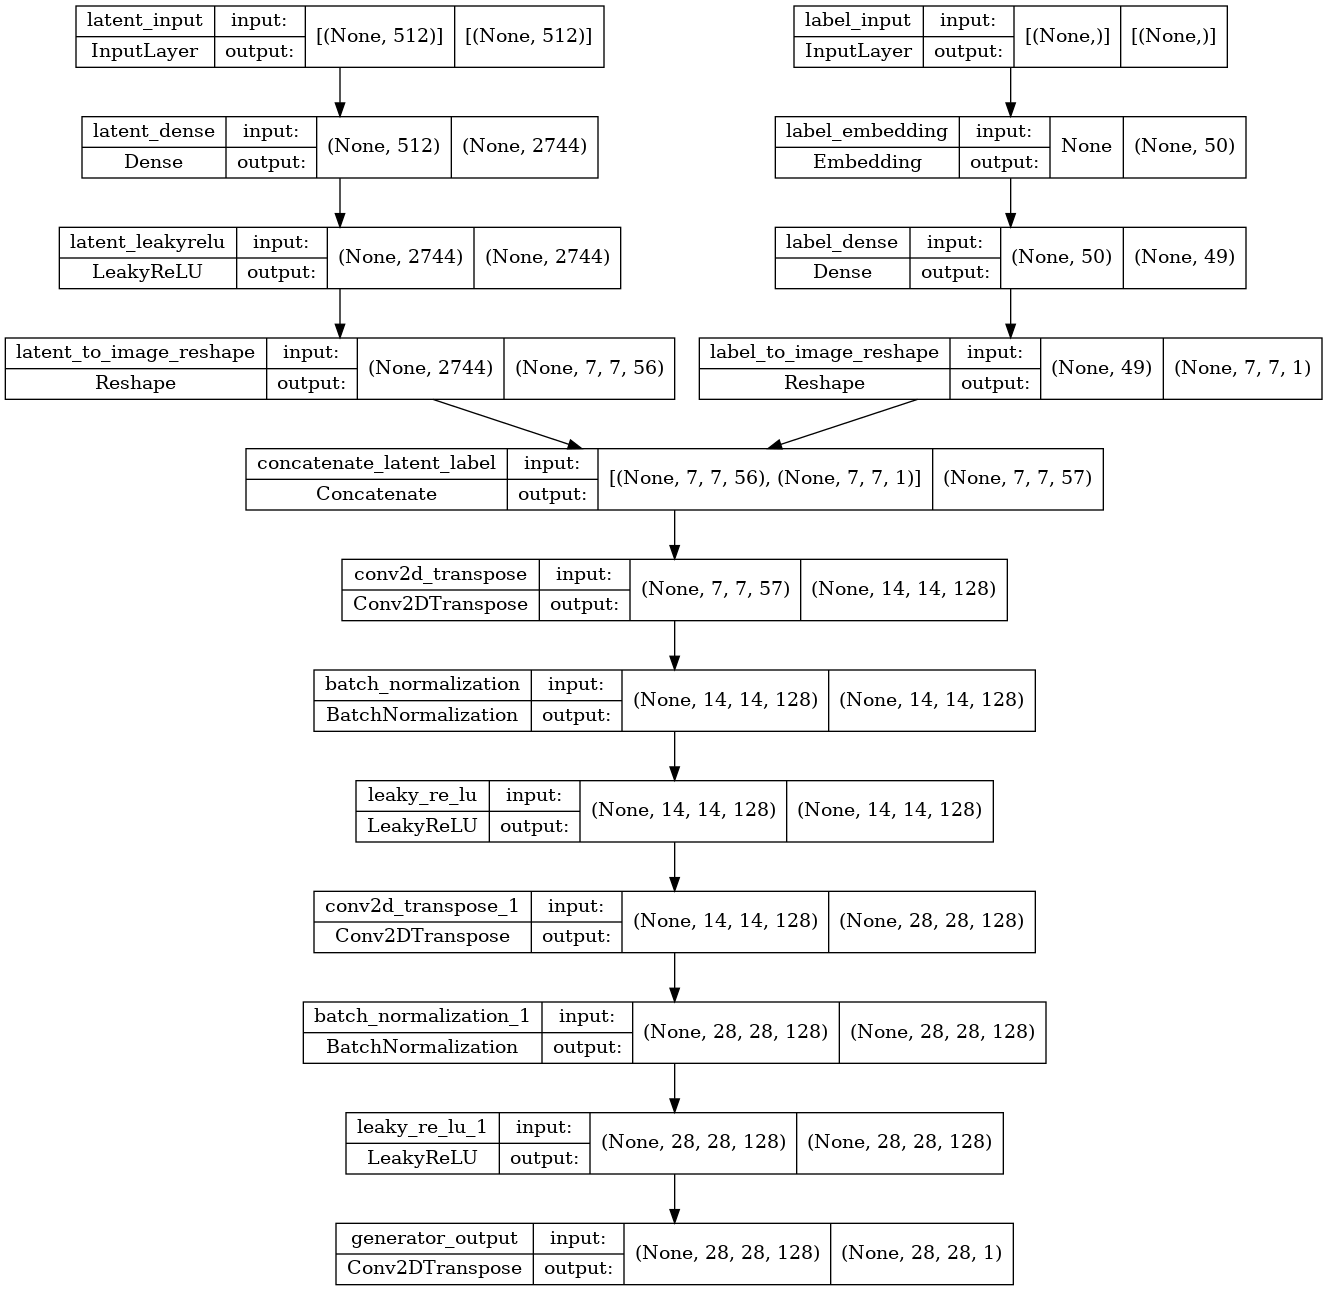

In [9]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_generator, show_shapes=True, show_layer_names=True
)

### The Discriminator

Next, we will build the discriminator. The discriminator is a CNN-based image classifier. It should take in an image of shape 28x28x1 and label represented in 28x28x1, and return a single classification indicating if that image is real or not.

In the same way as the generator, we define discriminator block (`create_discriminator_block`), discriminator stack (`standard_DCGAN_discriminator`), and entire model (`create_dcgan_discriminator`).

In [10]:
# Create the discriminator
def create_discriminator_block(
    inputs, filters, kernel_size, strides, padding, alpha
):
    """Creates discriminator block of layers.

    Args:
        inputs: tensor, rank 4 image tensor of shape
            (batch_size, height, width, channels).
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        outputs: tensor, rank 4 image tensor of shape
            (batch_size, height // 2, width // 2, filters).
    """
    x = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
    )(inputs=inputs)
    x = tf.keras.layers.BatchNormalization()(inputs=x)
    outputs = tf.keras.layers.LeakyReLU(alpha=alpha)(inputs=x)

    return outputs


def standard_DCGAN_discriminator(inputs):
    """Returns output of standard DCGAN discriminator layers.

    Args:
        inputs: tensor, rank 4 tensor of shape (batch_size, y, x, channels).

    Returns:
        outputs: tensor, rank 2 tensor of shape (batch_size, 1).
    """
    x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=1, padding="same"
    )(inputs=inputs)

    x = create_discriminator_block(
        inputs=x,
        filters=128,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2,
    )

    x = create_discriminator_block(
        inputs=x,
        filters=128,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2,
    )

    x = create_discriminator_block(
        inputs=x,
        filters=256,
        kernel_size=3,
        strides=2,
        padding="same",
        alpha=0.2,
    )

    x = tf.keras.layers.Flatten()(inputs=x)
    outputs = tf.keras.layers.Dense(name="discriminator_output", units=1)(
        inputs=x
    )

    return outputs


def create_dcgan_discriminator(image_shape, num_classes):
    """Creates deep convolutional conditional GAN discriminator model.

    Args:
        image_shape: tuple, the shape of the image without batch dimension.
        num_classes: int, the number of image classes.

    Returns:
        Keras Functional Model.
    """
    images = tf.keras.Input(name="image_input", shape=image_shape)

    labels = tf.keras.Input(name="label_input", shape=())
    label_image = create_label_images(
        labels=labels,
        num_classes=num_classes,
        embedding_dim=50,
        image_shape=image_shape,
    )

    concatenated_inputs = tf.keras.layers.Concatenate(
        name="concatenate_image_label", axis=-1
    )(inputs=[images, label_image])

    outputs = standard_DCGAN_discriminator(inputs=concatenated_inputs)

    return tf.keras.Model(
        inputs=[images, labels], outputs=outputs, name="dcgan_discriminator"
    )


dcgan_discriminator = create_dcgan_discriminator(
    image_shape=IMAGE_SHAPE, num_classes=NUM_CLASSES
)
dcgan_discriminator.summary()

Model: "dcgan_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 label_embedding (Embedding)    (None, 50)           500         ['label_input[0][0]']            
                                                                                                  
 label_dense (Dense)            (None, 784)          39984       ['label_embedding[0][0]']        
                                                                                                  
 image_input (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                

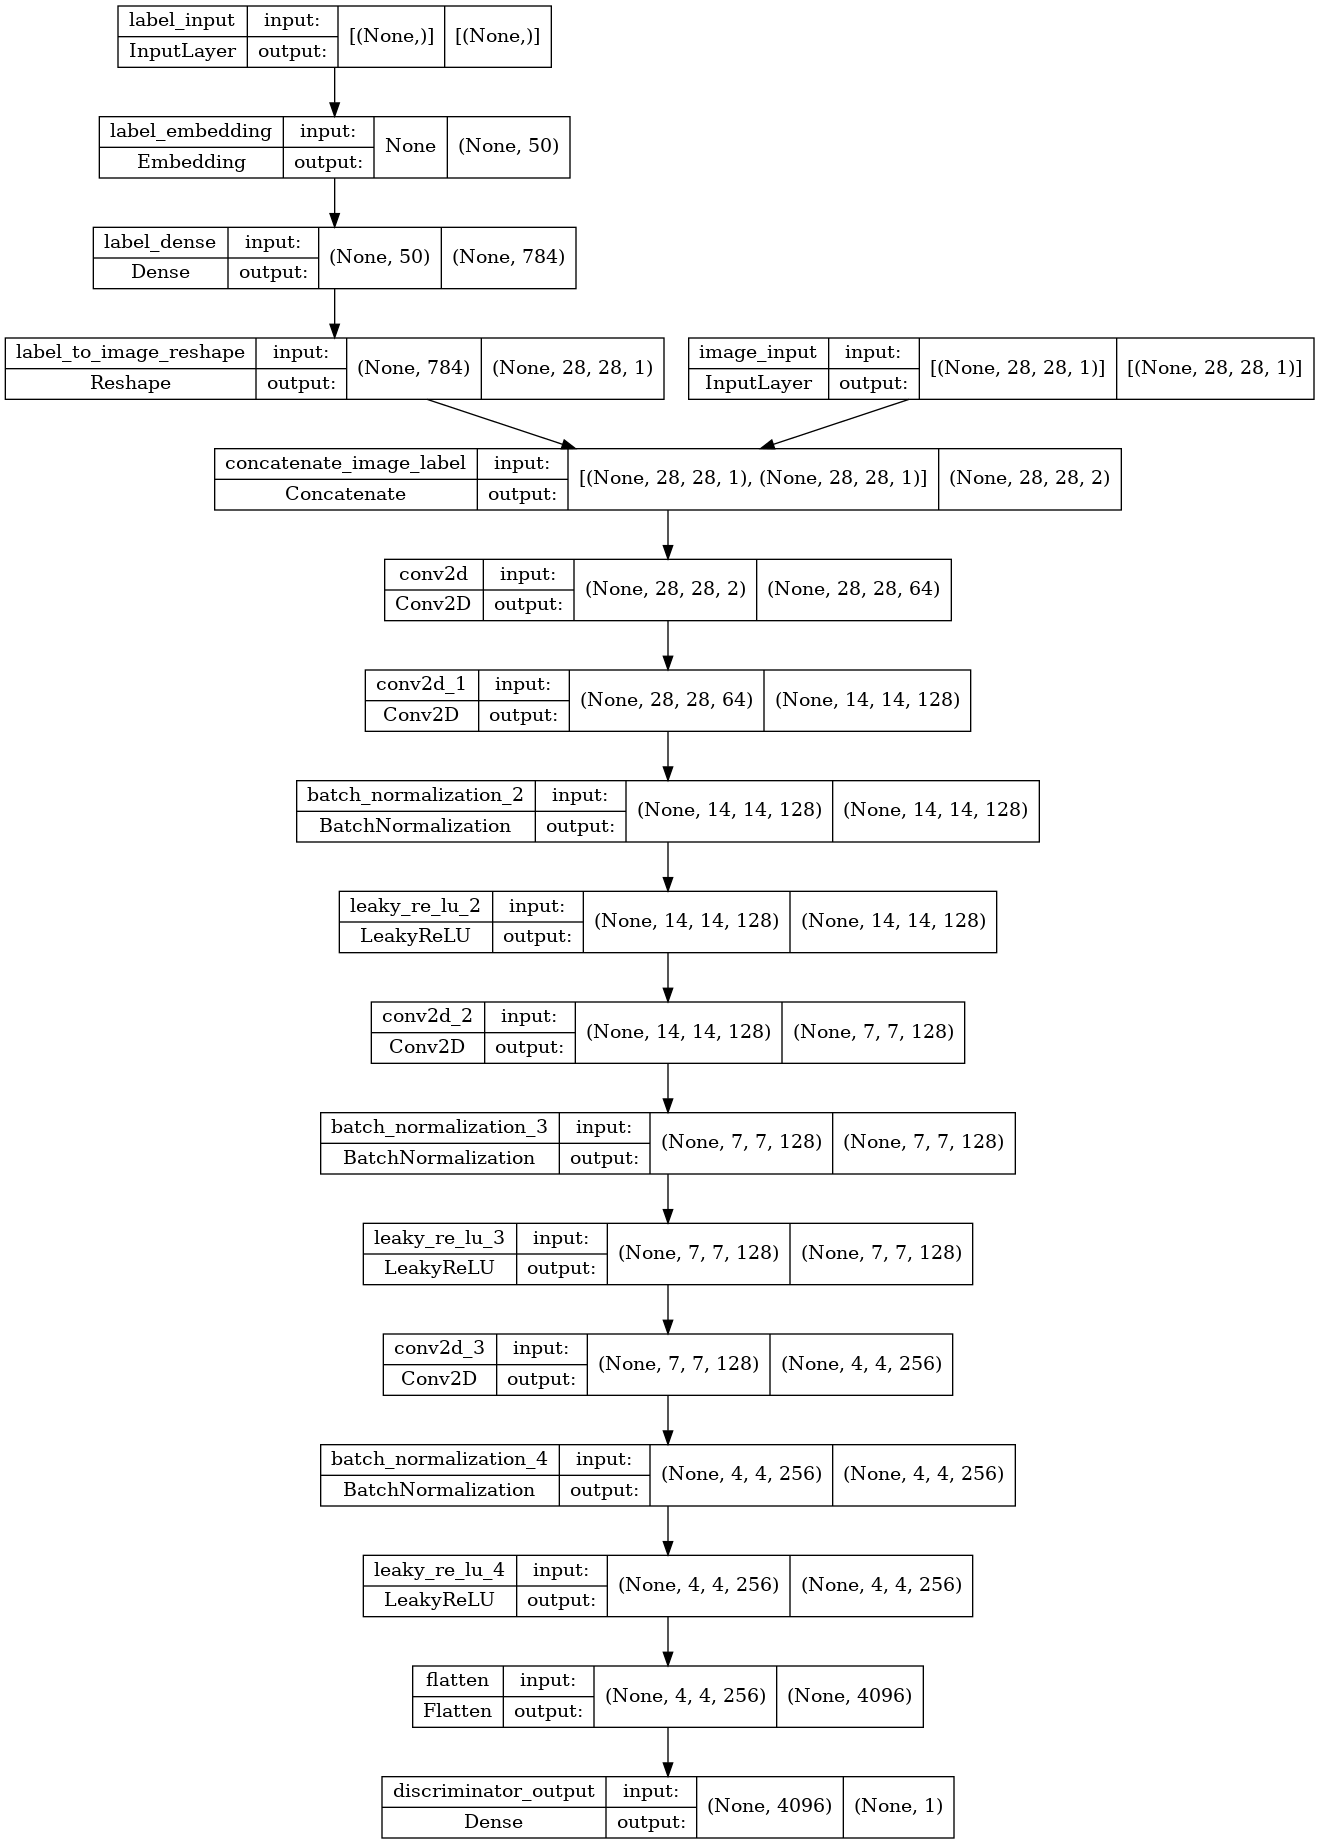

In [11]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=dcgan_discriminator, show_shapes=True, show_layer_names=True
)

We'll create a custom `Model` class named `GAN` that we can use to facilitate training of our generator and discriminator networks.

### Define GAN class
Now we have the generator and the discriminator model.

Let's combine them into a class by subclassing [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

By defining our own model class, we can use the standard model APIs like `model.fit()` by defining the original training steps and `model.save()` to save a model object in TensorFlow saved model format easily. Also, we can override the functions of tf.keras.Model to change behaviors of our model.

Here we define these functions in our Conditional_GAN class:
- `__init__`: instantiates model class
- `compile`: overrides the `Model.compile()` function to be able to define optimizers of a generator and a discriminator separately, and to add a loss function that is used in both models.
- `discriminator_train_step`: defines a discriminator specific training step
- `generator_train_step`: defines a generator specific training step
- `train_step`: overrides `Model.train_step` where we can define an original training step. Here we train a discriminator and a generator sequentially and return two losses.

Also, please note that we are adding **one-sided label smoothing** to our real labels, which involves multiplying labels by a float constant in the range [0.0, 1.0]. 
This helps the discriminator avoid becoming overconfident in its predictions based on only a small set of features within the images, which the generator may then exploit (causing it to become good at beating the discriminator but not at image generation).

In [12]:
class Conditional_GAN(tf.keras.Model):
    """Custom model for training a Conditional GAN.

    Attributes:
        discriminator: Keras `Model`, the discriminator network.
        generator: Keras `Model`, the generator network.
        latent_dim: int, the latent vector dimension length.
        one_sided_label_smoothing: float, how much to smooth the real image
            labels by value in [0., 1.].
        discriminator_optimizer: Keras `Optimizer`, optimizer for
            discriminator network.
        generator_optimizer: Keras `Optimizer`, optimizer for generator
            network.
        loss_fn: Keras `Loss`, loss function for training both networks.
    """

    def __init__(
        self, discriminator, generator, latent_dim, one_sided_label_smoothing
    ):
        """Instantiates `GAN` model class.

        Args:
            discriminator: Keras `Model`, the discriminator network.
            generator: Keras `Model`, the generator network.
            latent_dim: int, the latent vector dimension length.
            one_sided_label_smoothing: float, how much to smooth the real image
                labels by value in [0., 1.].
        """
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.one_sided_label_smoothing = one_sided_label_smoothing

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        """Overrides base `Model` class' compile method.

        Args:
            discriminator_optimizer: Keras `Optimizer`, optimizer for
                discriminator network.
            generator_optimizer: Keras `Optimizer`, optimizer for generator
                network.
            loss_fn: Keras `Loss`, loss function for training both networks.
        """
        super().compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn

    def discriminator_train_step(self, batch_size, real_images, input_labels):
        """Trains discriminator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.
            real_images: tensor, rank 4 tensor of real images with shape
                (batch_size, height, width, depth).
            input_labels: tensor, rank 1 tensor of labels with shape (batch_size,).

        Returns:
            discriminator_loss: tensor, scalar loss of disriminator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Generate images from noise.
        generated_images = self.generator(
            inputs=[random_latent_vectors, input_labels]
        )

        # Combine generated images with real images.
        combined_images = tf.concat(
            values=[generated_images, real_images], axis=0
        )

        # Create fake and real labels.
        fake_labels = tf.zeros(shape=(batch_size, 1))
        real_labels = tf.ones(shape=(batch_size, 1))

        # Smooth real labels to help with training.
        real_labels *= self.one_sided_label_smoothing

        # Combine labels to be in-line with combined images.
        labels = tf.concat(values=[fake_labels, real_labels], axis=0)

        # Train ONLY the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                inputs=[
                    combined_images,
                    tf.concat(values=[input_labels, input_labels], axis=0),
                ]
            )
            discriminator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=discriminator_loss,
            sources=self.discriminator.trainable_weights,
        )

        self.discriminator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.discriminator.trainable_weights)
        )

        return discriminator_loss

    def generator_train_step(self, batch_size, input_labels):
        """Trains generator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.
            input_labels: tensor, rank 1 tensor of labels with shape (batch_size,).

        Returns:
            generator_loss: tensor, scalar loss of generator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Create labels as if they're real images.
        labels = tf.ones(shape=(batch_size, 1))

        # Train ONLY the generator.
        with tf.GradientTape() as tape:
            fake_images = self.generator(
                inputs=[random_latent_vectors, input_labels]
            )
            predictions = self.discriminator(inputs=[fake_images, input_labels])
            generator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=generator_loss, sources=self.generator.trainable_weights
        )

        self.generator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.generator.trainable_weights)
        )

        return generator_loss

    def train_step(self, features):
        """Trains `GAN` for one step.

        Args:
            features: dict, images key has rank 4 tensor of real images with
                shape (batch_size, height, width, depth) for value and labels
                key has rank 1 tensor of labels with shape (batch_size,).

        Returns:
            losses: dict, dictionary of losses from each sub-training step.
        """
        real_images = features["images"]
        input_labels = features["labels"]

        # Get dynamic batch size to use for random noise vectors.
        batch_size = tf.shape(input=real_images)[0]

        # First train discriminator.
        discriminator_loss = self.discriminator_train_step(
            batch_size, real_images, input_labels
        )

        # Then train generator.
        generator_loss = self.generator_train_step(batch_size, input_labels)

        losses = {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss,
        }

        return losses

We can instantiate the Conditional GAN model and compile it.

In [13]:
# Instantiate a Conditional_GAN instance using our DCGAN generator and discriminator.
dcgan = Conditional_GAN(
    discriminator=dcgan_discriminator,
    generator=dcgan_generator,
    latent_dim=LATENT_DIM,
    one_sided_label_smoothing=0.9,
)

dcgan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

## Create input data pipeline with tf.data
Now our model is ready. Let's create a data pipeline with tf data. <br>
Note that we have to pass not only images but also labels to CGAN.


In [14]:
def create_train_dataset(batch_size):
    """Creates training dataset.

    Args:
        batch_size: int, number of elements in a mini-batch.

    Returns:
        dataset: `Dataset`, dataset object for training using MNIST.
    """
    # Get and format MNIST data.
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Let's combine both training and test sets.
    combined_images = np.concatenate([x_train, x_test])
    combined_images = (combined_images.astype("float32") - 127.5) / 255.0
    combined_images = np.reshape(combined_images, newshape=(-1, 28, 28, 1))

    combined_labels = np.concatenate([y_train, y_test])

    # Create tf.data.Dataset for training.
    dataset = tf.data.Dataset.from_tensor_slices(
        tensors={"images": combined_images, "labels": combined_labels}
    )
    dataset = dataset.shuffle(buffer_size=70000).batch(batch_size=batch_size)

    return dataset

## Train CGAN
We can train a model by simply calling `model.fit()`. <br>
It take around 7 minutes with a GPU.

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10  # Change numbers for better generation

# Train DCGAN model.
dcgan_history = dcgan.fit(
    create_train_dataset(batch_size=BATCH_SIZE), epochs=EPOCHS
)

Epoch 1/10


2022-06-01 12:51:00.423186: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


547/547 [==============================] - 45s 73ms/step - discriminator_loss: 0.5360 - generator_loss: 1.3744
Epoch 2/10
214/547 [==========>...................] - ETA: 23s - discriminator_loss: 0.4318 - generator_loss: 1.8638

Let's plot the loss history and some generated images using our trained model.

In [ ]:
def plot_loss_history(history):
    """Plots loss history.

    Args:
        history: `keras.callbacks.History`, history object from training job.
    """
    plt.plot(history.history["generator_loss"])
    plt.plot(history.history["discriminator_loss"])
    plt.title("Training losses")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["generator", "discriminator"], loc="upper left")
    plt.show()

In [ ]:
plot_loss_history(history=dcgan_history)

## Generate images
Now our CGAN is ready to generate images. Note that we can specify which number we want our generator to generate.

In [ ]:
LABEL_TO_GENERATE = 9  # 0-9
latent_vectors = tf.random.normal(shape=(1, LATENT_DIM))

generated_image = dcgan.generator(
    inputs=[latent_vectors, tf.constant([LABEL_TO_GENERATE], dtype=tf.int32)]
)
plt.imshow(
    tf.reshape(generated_image, generated_image.shape[1:-1]), cmap="gray"
)

Let's try to generate multiple numbers.

This is a helper function to visualize multiple images.

In [ ]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(tf.reshape(image, image.shape[:-1]), cmap="gray")
    plt.show()

In [ ]:
num_examples = 20
latent_vectors = tf.random.normal(shape=(num_examples, LATENT_DIM))
for i in range(10):
    labels = tf.ones(shape=num_examples, dtype=tf.int32) * i
    plot_images(images=dcgan.generator(inputs=[latent_vectors, labels]))

Looks good! You can try to get better images by specifying larger epochs (like 50).

##　Summary
In this notebook, we learned how to build and train a Conditional GAN model.


Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License